# How to organise machine learning experiments?


Thomas Boquet


github: [@tboquet](https://github.com/tboquet)

## Problems?

- Training **complex** machine learning **models** could take some **time** and **ressources**.

- It's **not efficient** for one researcher to run **several scripts sequentially** on a server.

- When you are in a team with **multiple researchers** using **multiple (GPU) servers** it becomes **a mess**.

- You also need to **save** the architecture, the parameters and more **infos** (data, dependencies, etc) about each **model**.

- The servers have to be configured (CUDA, Theano, etc.)

![image](http://images.techtimes.com/data/images/full/146106/macgyver-jpg.jpg)

It's **possible** to:

- **assign hardware** from the same machine or from **several servers** to an application (nvidia-docker)

- **save all the info** in a database

- retrieve the info, **rebuild the same models** and serve them in a **production pipeline**!

*(like TensorFlow Serving...)*

### Let's do this using a simple API!

# ALP

## How to use it?

(after the setup)

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense
from keras.layers import Input, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.test_utils import get_test_data
import numpy as np

from alp.appcom.core import Experiment

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


### Fake data stuff

In [2]:
np.random.seed(1337)


input_dim = 2
nb_hidden = 4
nb_class = 10
batch_size = 128
train_samples = 40000
test_samples = 2000

In [3]:
(X_tr, y_tr), (X_te, y_te) = get_test_data(nb_train=train_samples,
                                            nb_test=test_samples,
                                            input_shape=(input_dim,),
                                            classification=True,
                                            nb_class=nb_class)

y_tr = np_utils.to_categorical(y_tr)
y_te = np_utils.to_categorical(y_te)

data, data_val = dict(), dict()

data["X"] = X_tr
data["y"] = y_tr

data_val["X"] = X_te
data_val["y"] = y_te


metrics = ['accuracy']

### Model!

In [4]:
model = Sequential()
model.add(Dense(nb_hidden, input_dim=input_dim, activation='relu'))
model.add(Lambda(lambda x: x + x**2 + x**3))
model.add(Dense(nb_class, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

expe = Experiment(model)

Fontconfig warning: ignoring C.UTF-8: not a valid language tag



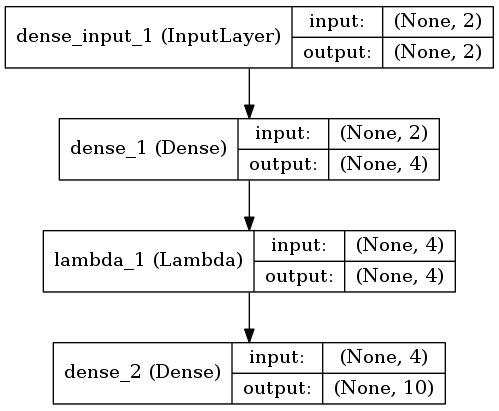

In [5]:
from IPython.display import Image
from keras.utils.visualize_util import model_to_dot

Image(model_to_dot(model, show_shapes=True).create(prog='dot', format='png'))

### Simple fit

In [6]:
history_1 = expe.fit([data], [data_val], nb_epoch=40, batch_size=batch_size, verbose=0)

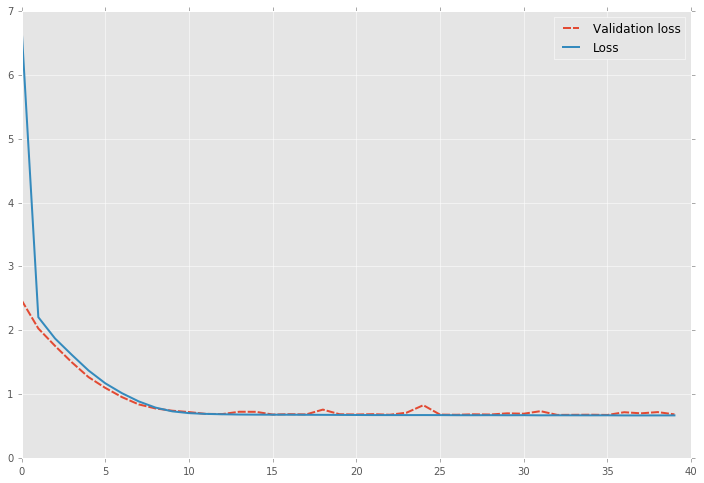

In [7]:
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(history_1['metrics']["val_loss"], dashes=[8,2], linewidth=2, label="Validation loss")
plt.plot(history_1['metrics']["loss"], linewidth=2, label="Loss")
plt.legend()
plt.show()

### In async mode!

In [8]:
model = Sequential()
model.add(Dense(nb_hidden, input_dim=input_dim, activation='relu'))
model.add(Lambda(lambda x: x + x**2 + x**3))
model.add(Dense(nb_class, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

expe = Experiment(model)

expe.fit_async([data], [data_val],
               nb_epoch=40, batch_size=batch_size)

<AsyncResult: 5c427083-6d01-45a0-9fee-cc3184cd5545>

Result d36769605b9c5c7dafee303d6024b010 ready


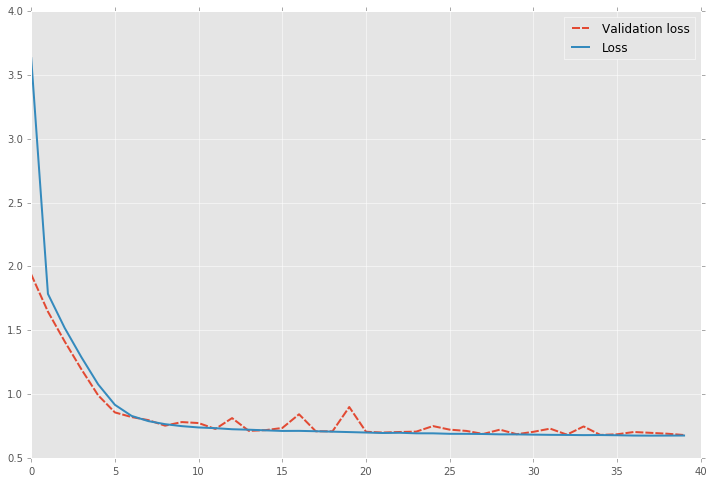

In [9]:
history_2 = expe.full_res
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(history_2['metrics']["val_loss"], dashes=[8,2], linewidth=2, label="Validation loss")
plt.plot(history_2['metrics']["loss"], linewidth=2, label="Loss")
plt.legend()
plt.show()

### First look at the architecture

![arch](http://python-alp.readthedocs.io/en/latest/_images/architecture.svg)

## What happened?

![celery](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/celery.gif)

![task_celery](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/task_celery.png)

## Let's send a lot of models

In [10]:
expes = []
for i in range(20):
    model = Sequential()
    model.add(Dense(nb_hidden + i, input_dim=input_dim, activation='relu'))
    model.add(Lambda(lambda x: x + x**2 + x**3))
    model.add(Dense(nb_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    expe = Experiment(model)

    print(expe.fit_async([data], [data_val],
                         nb_epoch=40, batch_size=batch_size))
    expes.append(expe)

4f924005-c923-4ac8-84cd-32af86f5f7b8
a35c6da6-9147-4d46-b3a2-ecde8f0c0782
e6d78664-60c3-48b1-b6d2-f1127c2c52b5
706f93c3-b048-4eef-8fe8-e158ea2857c2
024a4484-70c8-4110-83a5-4bf60b0dda3b
f358bb65-3d3a-450d-adb6-f97c73be4e21
865ee09c-bcf8-409a-85d7-e09f87d20a3c
ff7566fd-60e4-4054-8984-9586cd490c1e
d4c9851b-e49d-4530-a2ba-09ca84002b36
3c6e8301-9a02-4e2e-aa7a-9a0ec89fcd0d
0a688299-cf0c-4050-8796-0b4f1fe1dab4
e928d259-22f3-4c09-9490-0a8c082db889
6c8c1892-2e6a-4652-86b8-3ac2da471510
0cb0ae09-5c82-4e24-9dde-7cffbd0965d3
c9325177-af6f-43e8-a41e-708364f86b85
ca076aeb-acd1-4a95-aa38-e41c038561b9
11fc180e-cdb1-4566-9c20-426cba16da18
8bc8c3c3-8a33-4880-8f2f-1124fed4c3a8
cad5c96c-6bc0-41be-b2d1-a3bde80753b3
cebcbb60-c89a-4afb-bdd0-055c97a21595
Result 1ddb727bd2e63c316cdb9e7b56637c27 ready
Result db7789d4cdc2786ea5d9322a4ae466a4 ready
Result 3e2045346f9c2d84418195005e3853d9 ready
Result 24780230b9b3a14fb83c3c2245d2fa96 ready
Result 38f1380a8ade31d2fe2aea65b389674a ready
Result 87ab5f1a01bc428ae3b9072

## We could take a look at Celery and RabbitMQ's admin panel

![queue_rabbit](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/queue_rabbit.png)

![queue](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/queue.gif)

## And the processes using the GPU(s)

![gpu_processes](https://raw.githubusercontent.com/tboquet/presentations/master/static/alp/gpu_processes.gif)

# Prediction

In [11]:
predictions = expes[2].predict([data['X']])
print(predictions[0].shape)
predictions[0]

(40000, 10)


array([[  0.00000000e+00,   0.00000000e+00,   6.48656976e-34, ...,
          1.00533158e-01,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          9.95051861e-01,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.77754760e-01,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          9.99994397e-01,   0.00000000e+00,   0.00000000e+00],
       [  2.25554009e-24,   2.17307249e-11,   3.21463813e-05, ...,
          1.09264938e-05,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          9.98950124e-01,   0.00000000e+00,   0.00000000e+00]], dtype=float32)

# Thank you!


**[Alp's doc](http://python-alp.readthedocs.io/en/latest/)**


**[Alp on github](https://github.com/tboquet/python-alp)**
